## Problem statement:
Build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#unzip the dataset
!unzip "/content/gdrive/My Drive/CNN_assignment.zip" > /dev/null

replace Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [ ]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Data Visualization**

Found 6739 files belonging to 9 classes.


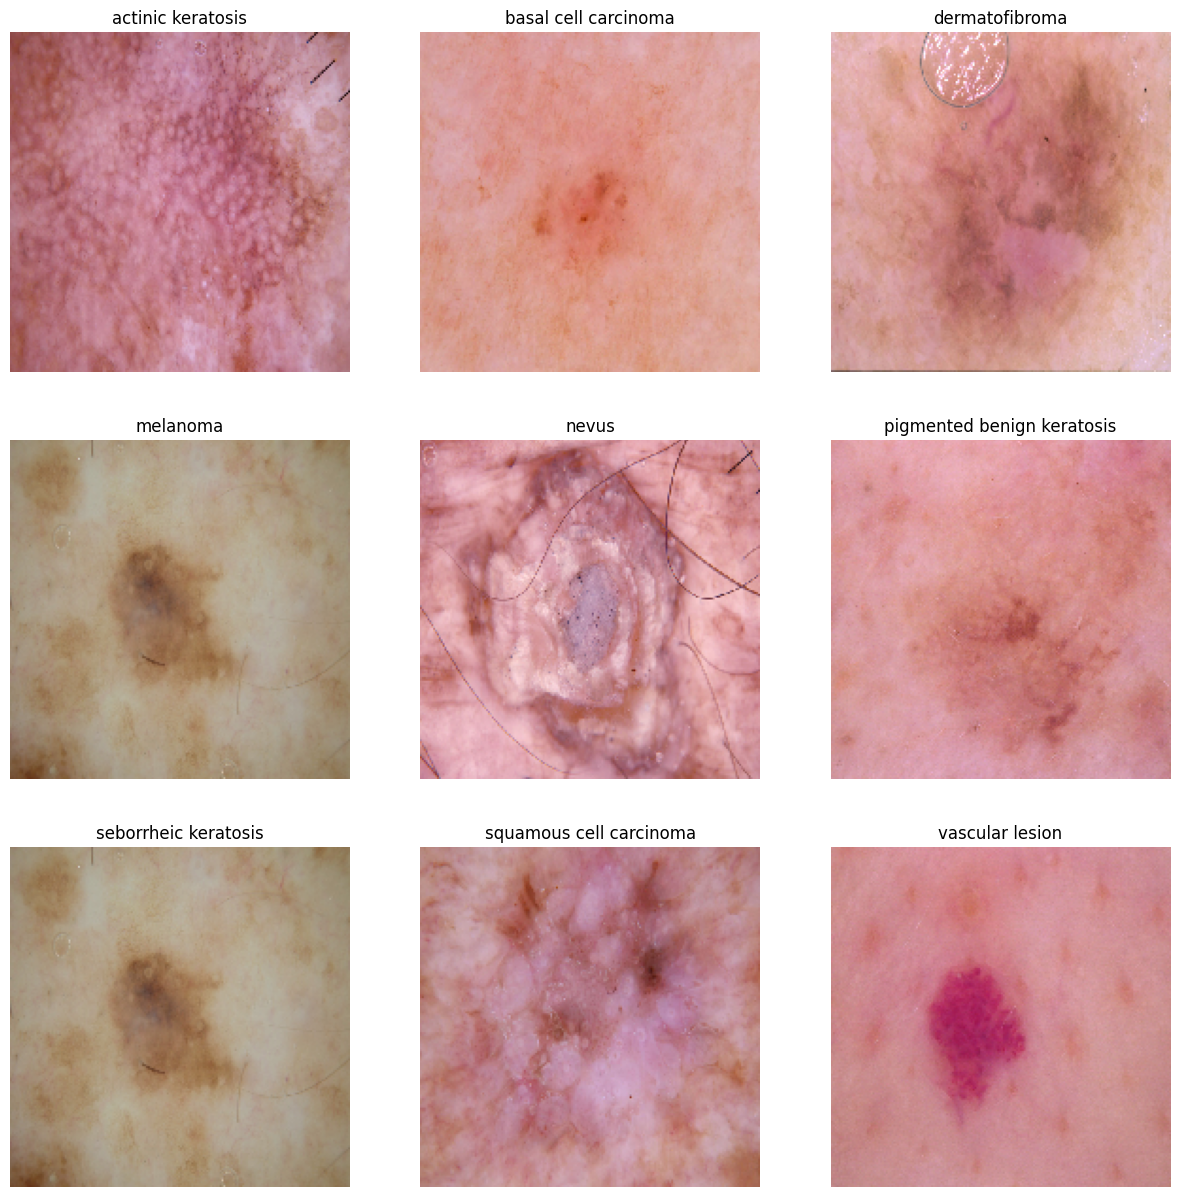

In [ ]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

**Visualize distribution of classes in the training dataset.**

In [ ]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,vascular lesion,139
1,dermatofibroma,95
2,seborrheic keratosis,77
3,basal cell carcinoma,376
4,actinic keratosis,114
5,pigmented benign keratosis,462
6,squamous cell carcinoma,181
7,melanoma,438
8,nevus,357


<Axes: xlabel='No. of Image', ylabel='Class'>

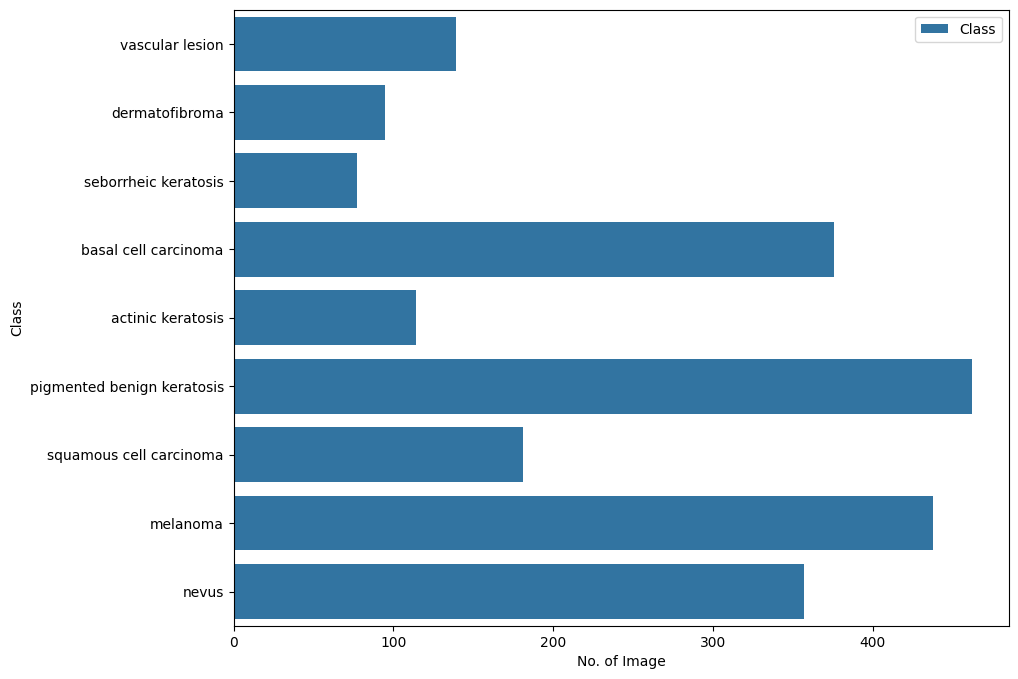

In [ ]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

There is a class imbalance to solve this using a python package  Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
#install Augmentor
!pip install Augmentor

In [ ]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7805F9949A10>: 100%|██████████| 500/500 [00:18<00:00, 27.12 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7805AC5DCF50>: 100%|██████████| 500/500 [00:15<00:00, 32.51 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7806C5F7BA50>: 100%|██████████| 500/500 [00:13<00:00, 35.96 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7806101A1E50>: 100%|██████████| 500/500 [01:24<00:00,  5.89 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x78061015FBD0>: 100%|██████████| 500/500 [01:11<00:00,  7.03 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7805AC5A4290>: 100%|██████████| 500/500 [00:13<00:00, 37.26 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7805AC44BCD0>: 100%|██████████| 500/500 [00:31<00:00, 15.71 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7806101D3A10>: 100%|██████████| 500/500 [00:12<00:00, 38.68 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7805F9954F50>: 100%|██████████| 500/500 [00:14<00:00, 35.14 Samples/s]


In [ ]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


**Model Building**

In [ ]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [ ]:
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [ ]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

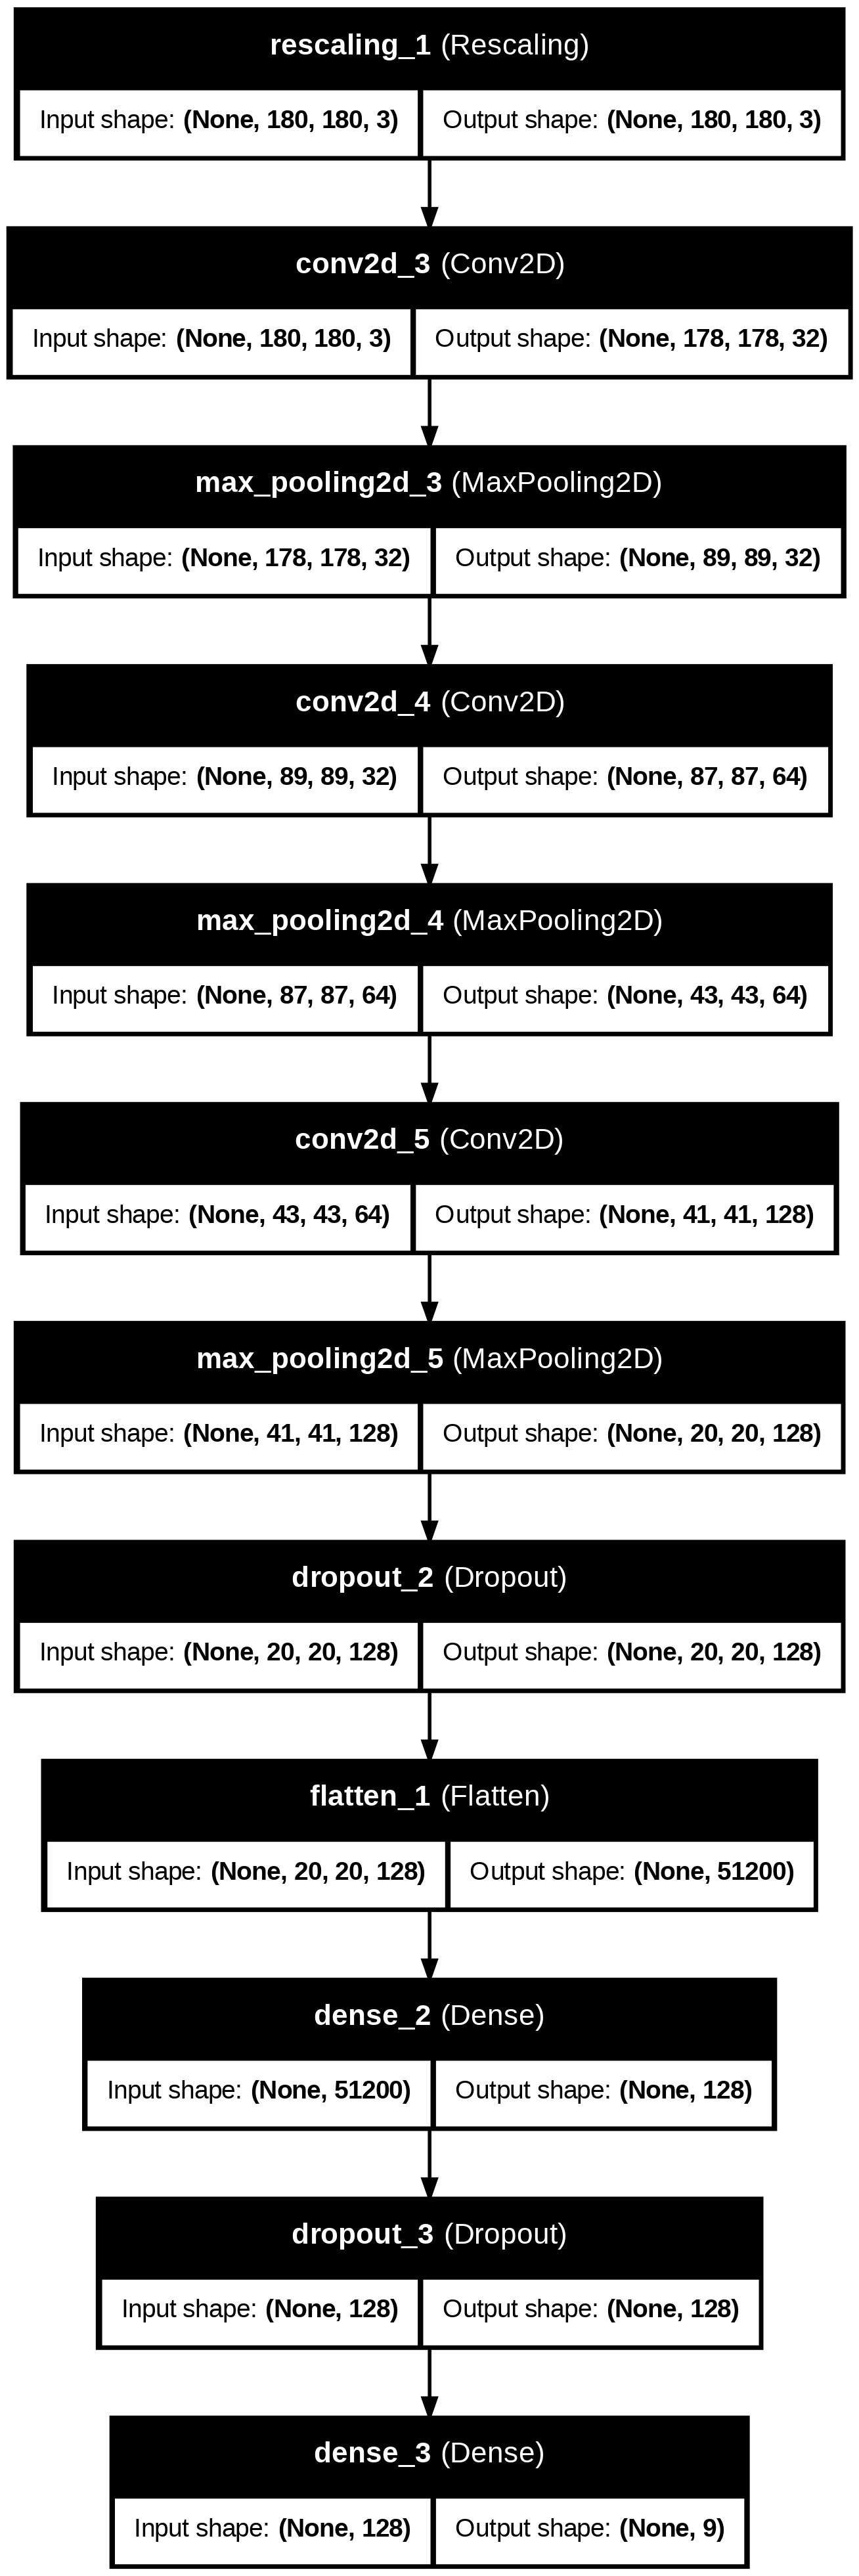

In [ ]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [ ]:
# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2643 - loss: 1.9176
Epoch 1: val_accuracy improved from -inf to 0.42012, saving model to model.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 66s 105ms/step - accuracy: 0.2646 - loss: 1.9168 - val_accuracy: 0.4201 - val_loss: 1.5453
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4543 - loss: 1.4302
Epoch 2: val_accuracy improved from 0.42012 to 0.51402, saving model to model.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.4544 - loss: 1.4301 - val_accuracy: 0.5140 - val_loss: 1.2836
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5264 - loss: 1.2833
Epoch 3: val_accuracy improved from 0.51402 to 0.59368, saving model to model.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.5264 - loss: 1.2832 - val_accuracy: 0.5937 - val_loss: 1.1034
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5728 - loss: 1.1262
Epoch 4: val_accuracy improved from 0.59368 to 0.59947, saving model to model.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.5728 - loss: 1.1261 - val_accuracy: 0.5995 - val_loss: 1.0435
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6145 - loss: 1.0378
Epoch 5: val_accuracy improved from 0.59947 to 0.65465, saving model to model.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.6145 - loss: 1.0376 - val_accuracy: 0.6547 - val_loss: 0.8947
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6924 - loss: 0.8366
Epoch 6: val_accuracy improved from 0.65465 to 0.72007, saving model to model.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.6924 - loss: 0.8366 - val_accuracy: 0.7201 - val_loss: 0.8439
Epoch 7/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7071 - loss: 0.7843
Epoch 7: val_accuracy improved from 0.72007 to 0.72853, saving model to model.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.7072 - loss: 0.7843 - val_accuracy: 0.7285 - val_loss: 0.7313
Epoch 8/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7451 - loss: 0.6677
Epoch 8: val_accuracy improved from 0.72853 to 0.78816, saving model to model.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.7451 - loss: 0.6677 - val_accuracy: 0.7882 - val_loss: 0.6342
Epoch 9/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7773 - loss: 0.6152
Epoch 9: val_accuracy improved from 0.78816 to 0.81753, saving model to model.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7773 - loss: 0.6152 - val_accuracy: 0.8175 - val_loss: 0.5213
Epoch 10/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7947 - loss: 0.5411
Epoch 10: val_accuracy improved from 0.81753 to 0.81798, saving model to model.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7947 - loss: 0.5410 - val_accuracy: 0.8180 - val_loss: 0.5684
Epoch 11/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8162 - loss: 0.4957
Epoch 11: val_accuracy did not improve from 0.81798
281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8162 - loss: 0.4958 - val_accuracy: 0.8082 - val_loss: 0.5740
Epoch 12/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8376 - loss: 0.4439
Epoch 12: val_accuracy improved from 0.81798 to 0.85403, saving model to model.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.8376 - loss: 0.4439 - val_accuracy: 0.8540 - val_loss: 0.4581
Epoch 13/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8300 - loss: 0.4310
Epoch 13: val_accuracy did not improve from 0.85403
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8300 - loss: 0.4311 - val_accuracy: 0.8264 - val_loss: 0.5317
Epoch 14/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8363 - loss: 0.4349
Epoch 14: val_accuracy improved from 0.85403 to 0.86916, saving model to model.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8363 - loss: 0.4348 - val_accuracy: 0.8692 - val_loss: 0.4195
Epoch 15/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8542 - loss: 0.3861
Epoch 15: val_accuracy improved from 0.86916 to 0.88340, saving model to model.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8542 - loss: 0.3861 - val_accuracy: 0.8834 - val_loss: 0.3999
Epoch 16/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8649 - loss: 0.3631
Epoch 16: val_accuracy did not improve from 0.88340
281/281 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.8649 - loss: 0.3632 - val_accuracy: 0.8816 - val_loss: 0.4171
Epoch 17/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8601 - loss: 0.3793
Epoch 17: val_accuracy did not improve from 0.88340
281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8601 - loss: 0.3793 - val_accuracy: 0.8781 - val_loss: 0.4031
Epoch 18/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8837 - loss: 0.3185
Epoch 18: val_accuracy improved from 0.88340 to 0.89319, saving model to model.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8837 - loss: 0.3185 - val_accuracy: 0.8932 - val_loss: 0.3750
Epoch 19/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8918 - loss: 0.3021
Epoch 19: val_accuracy did not improve from 0.89319
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8917 - loss: 0.3021 - val_accuracy: 0.8892 - val_loss: 0.4005
Epoch 20/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8776 - loss: 0.3295
Epoch 20: val_accuracy improved from 0.89319 to 0.90031, saving model to model.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.8776 - loss: 0.3295 - val_accuracy: 0.9003 - val_loss: 0.3892


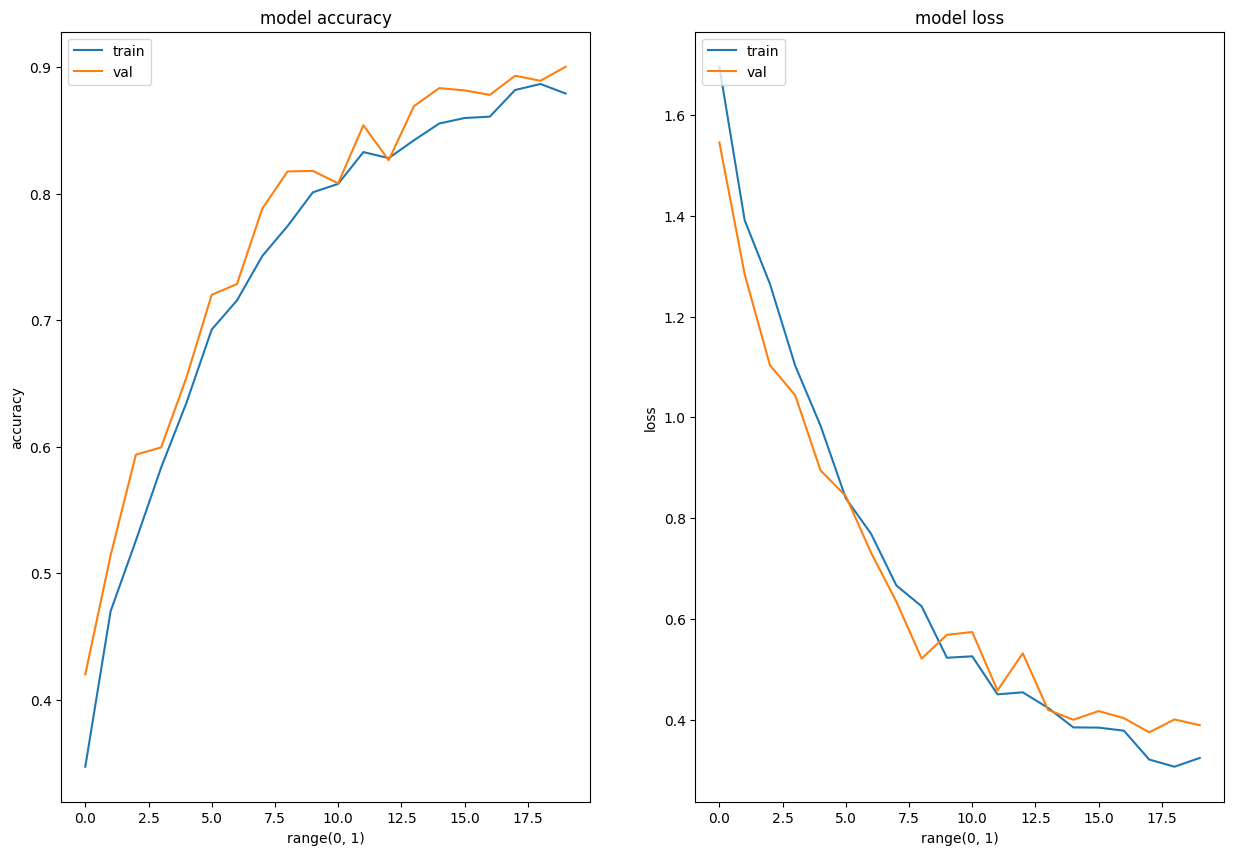

In [ ]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## Model Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


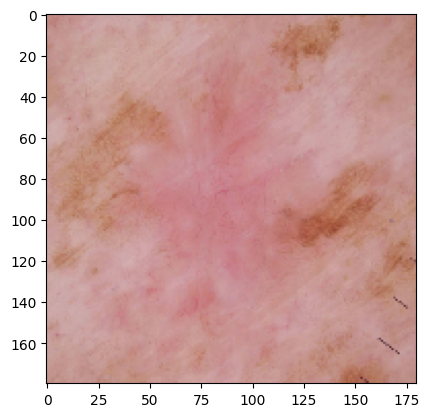

In [ ]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )